In [1]:
import numpy as np
import os
import torch
import numpy as np
import torchvision
from src.trak_utils import get_scores
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn as nn
from src.models import CustomResNet
from src.utils import read_yaml
from run_vanilla_trak import fix_checkpoint, get_ds_loaders
import tqdm
# from manual_fairness.manual_annots import ANNOTATIONS

In [2]:
ANNOTATIONS = {
    0: [
        0,0,1,1,0, #1-5
        0,1,1,1,1, #6-10
        0,1,1,1,1, #11-15
        0,0,0,1,1, #16-20
        1,0,0,1,1, #21-25
        1,0,0,1,1, #26-30
        0,1,1,0,0, #31-35
        0,0,0,0,1, #36-40
        1,1,1,1,1, #41-45
        1,0,1,1,1  #46-50
    ],
    271: [
        0, 0, 0, 0, 1, # 1-5
        1, 1, 1, 0, 1, # 2-10
        0, 1, 0, 0, 0, # 11-15
        1, 0, 1, 1, 0, # 16-20
        1, 1, 0, 0, 0, # 21-25
        0, 0, 1, 1, 0, # 26-30
        0, 0, 0, 1, 1, # 31-35
        1, 0, 0, 1, 1, # 36-40
        1, 0, 1, 0, 0, # 41-45
        0, 1, 0, 0, 0 # 45-60
    ],
    938: [
        0, 0, 1, 1, 0,
        0, 0, 0, 0, 0,
        1, 0, 0, 1, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 1, 0, 0,
        0, 0, 0, 1, 0,
        1, 0, 0, 0, 1,
        1, 1, 0, 0, 0,
        0, 0, 1, 0, 0,
    ],
    949: [
        0, 1, 1, 0, 1, #1-5
        0, 0, 0, 1, 0, # 6-10
        1, 1, 0, 1, 0, # 11-15
        1, 1, 1, 1, 1, # 16-20
        1, 1, 0, 1, 0, # 21-25
        0, 0, 0, 0, 1, # 26-30
        0, 0, 0, 0, 0, # 31-35
        0, 1, 1, 1, 0, # 36-40
        1, 0, 1, 1, 0, # 41-45
        0, 1, 1, 1, 1 # 45-50
    ]
}

VAL_ANNOTS = {
    0: [ # human including torso
        1, 0, 1, 0, 1,
        1, 1, 1, 0, 1,
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 0,
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 
        0, 0, 1, 0, 1,
        1, 1, 1, 0, 1,
        0, 1, 1, 1, 1,
        0, 1, 1, 0, 0,
        1, 0, 1, 0, 0,
        1, 0, 0, 1, 0,
        0, 0, 0, 0, 0,
        1, 1, 0, 1, 1,
        0, 0, 1, 0, 1,
        0, 1, 1, 0, 0,
        1, 1, 1, 0, 1,
        1, 0, 1, 1, 0,
        0, 0, 0, 1, 1,
        1, 0, 0, 1, 0,
        1, 1, 0, 1, 1,
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 
        1, 0, 0, 1, 0,
        1, 0, 1, 1, 1,
        1, 1, 1, 1, 0],
    271: [ # grey coat
        0, 0, 0, 1, 1,
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 
        1, 1, 0, 0, 1, 
        1, 1, 1, 0, 1, 
        1, 1, 0, 1, 1, 
        0, 1, 1, 1, 0,
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 
        0, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 
        0, 1, 0, 1, 1, 
        1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1, 
        0, 1, 1, 1, 1, 
        1, 0, 1, 1, 1, 
        1, 1, 1, 1, 1, 
        1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 
        0, 1, 1, 1, 0,
        0, 1, 1, 0, 0],
    938: [ # cooked cauliflower
        1, 0, 0, 0, 0,
        1, 1, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 1, 1, 0, 0,
        1, 1, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 1,
        0, 0, 0, 0, 1,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        1, 1, 0, 1, 0,
        1, 0, 0, 0, 0,
        1, 1, 0, 0, 0,
        0, 0, 1, 1, 0,
        0, 1, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 
        0, 0, 0, 0, 0, 
        0, 0, 1, 1, 0,
        1, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
    ],
    949: [
        0, 0, 1, 0, 0, # in a plate or basket
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 1, 0, 1,
        1, 0, 0, 0, 0,
        1, 0, 0, 0, 0,
        0, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 
        1, 0, 0, 1, 0,
        0, 0, 1, 1, 0,
        1, 1, 0, 0, 0,
        0, 1, 0, 0, 0,
        0, 0, 1, 0, 1,
        0, 1, 0, 0, 1,
        0, 0, 1, 0, 0,
        0, 0, 0, 0, 0,
        1, 0, 0, 0, 1,
        0, 0, 0, 1, 1,
        1, 0, 1, 0, 0,
        0, 1, 0, 1, 1,
        0, 0, 0, 0, 0,
        0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 
        0, 0, 0, 1, 0,
    ],
}

In [3]:
splits = "/mnt/xfs/projects/trak_transfer_fairness_imagenet_data/splits"
all_train_inds = np.load(os.path.join(splits, "imagenet_train_inds.npy"))
all_val_inds = np.load(os.path.join(splits, "imagenet_val_inds.npy"))


In [4]:
in_ds = torchvision.datasets.ImageFolder("/mnt/cfs/datasets/pytorch_imagenet/train")
train_in_ds = torch.utils.data.Subset(in_ds, all_train_inds)
val_in_ds = torch.utils.data.Subset(in_ds, all_val_inds)
test_in_ds = torchvision.datasets.ImageFolder("/mnt/cfs/datasets/pytorch_imagenet/val")
targets = {
    'val': np.array(in_ds.targets)[all_val_inds],
    'test': np.array(test_in_ds.targets)
}

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
])

In [5]:
cls = 0
USE_PCA = True


score_path = f"/mnt/xfs/projects/trak_fairness/imagenet/vanilla_imagenet_trak_results/scores/{cls}_scores.npy"
scores = torch.tensor(np.load(score_path))
gt_annots = np.array(ANNOTATIONS[cls])

if USE_PCA:
    val_gt_annots = None
else:
    val_gt_annots = np.array(VAL_ANNOTS[cls])

cls_inds = { split: np.where(targets[split] == cls)[0] for split in ['val', 'test']}


In [231]:
# np.save("val_in_labels.npy", np.array(in_ds.targets)[val_inds])

In [233]:

# for i in cls_inds['test']:
#     print(i+1)
#     display(transform(test_in_ds[i][0]))

# fig, ax = None, None
# for idx, i in enumerate(cls_inds['val']):
#     if idx % 5 == 0:
#         if idx > 0:
#             plt.show()
#         fig, ax = plt.subplots(1, 5, figsize=(10, 3))
#     ax[idx % 5].imshow(transform(val_in_ds[i][0]))
#     ax[idx % 5].axis(False)
#     ax[idx % 5].set_title(f"{idx + 1}")
#     # display(transform(val_in_ds[i][0]))
# plt.show()

In [47]:
baselines_dir = "/mnt/xfs/projects/trak_fairness/imagenet/cfs/results/baseline_runs"
full_accs = {}
full_losses = {}
for split in ['val', 'test']:
    accs = []
    loss = []
    for p in os.listdir(baselines_dir):
        out = torch.load(os.path.join(baselines_dir, p, "results.pt"))['pretrain'][split]
        accs.append(out['preds'] == out['labels'])
        loss.append(out['losses'])
    full_accs[split] = np.stack(accs).astype(float)
    full_losses[split] = np.stack(loss).astype(float)
val_cls_accuracies = full_accs['val'].mean(0)[cls_inds['val']]
val_cls_losses = torch.tensor(full_losses['val'].mean(0)[cls_inds['val']]).float()

NameError: name 'cls_inds' is not defined

In [ ]:
# combined_results = torch.load("imagenet_combined_results.pt")
# full_accs = (combined_results['preds'] == combined_results['labels']).float()
# accuracies = full_accs.mean(0)[val_inds]
# criterion = nn.CrossEntropyLoss(reduction='none')
# all_loss = torch.zeros(len(combined_results['labels'][0])).float()
# for i in tqdm.tqdm(range(len(combined_results['logits']))):
#     logits = combined_results['logits'][i].float().cuda()
#     labels = combined_results['labels'][0].cuda()
#     all_loss += criterion(logits,  labels).cpu()
# avg_losses = (all_loss / len(combined_results['logits']))[val_inds]

In [48]:
from sklearn.decomposition import PCA

def get_projs(scores):
    S = torch.tensor(scores).cuda()
    S /= (S.norm(dim=1, keepdim=True) + 1e-5)
    S = S.float()

    pca = PCA(n_components=20)
    assert S.isnan().sum().item() == 0

    pca.fit(S.cpu().numpy())

    pcs = torch.tensor(pca.components_).float().cuda()
    projs = (S @ pcs.T).cpu().numpy().T

    return projs

In [49]:
import seaborn as sns

projs = get_projs(scores.numpy().T)


0


NameError: name 'cls_inds' is not defined

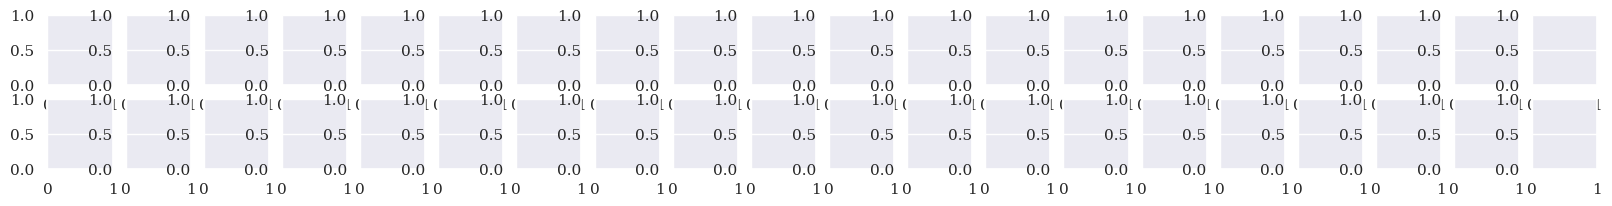

In [50]:
os.makedirs("fairness_plots", exist_ok=True)
for comp in range(1): # 3
    print(comp)
    order_ = np.argsort(projs[comp])
    num_imgs = 20
    fig, ax_ = plt.subplots(2, num_imgs, figsize=(num_imgs, 2))
    for j, order in enumerate([order_[::-1], order_]):
        ax = ax_[j]
        for i in range(len(ax)):
            val_index = order[i]
            img, label = val_in_ds[cls_inds['val'][val_index]]
            ax[i].imshow(transform(img))
            ax[i].set_title(f"{projs[comp][order[i]]:0.3f}")
            ax[i].axis(False)
    plt.tight_layout()
    plt.savefig(f"fairness_plots/{cls}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
import scipy


In [ ]:


if USE_PCA:
    
    top_comp = projs[0]
    minority_frac = int(0.35 * len(top_comp))
    order = np.argsort(top_comp)
    rev_order = np.argsort(-top_comp)

    
    if val_cls_accuracies[order[:minority_frac]].mean() >  val_cls_accuracies[rev_order[:minority_frac]].mean():
        print("reversing")
        order = rev_order
    
    # vals = np.cumsum(val_cls_accuracies[order])/(np.arange(130)+1)
    # vals[:5] = 1
    # print(minority_frac, np.argmin(vals))
    # sns.lineplot(y=vals, x=np.arange(len(vals)))
    
    group_labels = np.zeros(len(top_comp), dtype=int)
    group_labels[order[:minority_frac]] = 1
else:
    group_labels = val_gt_annots
print("Accuracies", val_cls_accuracies[group_labels==0].mean(), val_cls_accuracies[group_labels==1].mean())

losses_by_group = []
for k in range(group_labels.max()+1):
    mask = group_labels == k
    losses_by_group.append(val_cls_losses[mask].mean())
losses_by_group = torch.stack(losses_by_group)
print("Losses", losses_by_group)

In [ ]:
# weighted group avg margin
weighted_avgs_loss = []
for k in range(group_labels.max()+1):
    #loss weight
    mask = group_labels == k
    weight = torch.exp(val_cls_losses[mask].mean())
    print(weight)
    weighted_avgs_loss.append(scores[:, mask].mean(1) * weight)
    
weighted_avgs_loss = torch.stack(weighted_avgs_loss).sum(0).cpu().numpy()
exp_weighted_avgs_loss = np.argsort(weighted_avgs_loss)

scores_in_order = weighted_avgs_loss[exp_weighted_avgs_loss]
heuristic_index = len(np.where(scores_in_order < 0)[0])
print(heuristic_index)

In [ ]:
# save_dir = "/mnt/xfs/projects/trak_fairness/imagenet/cfs/orders"
# if USE_PCA:
#     np.save(os.path.join(save_dir, f"exp_weighted_avgs_loss_{cls}.npy"), exp_weighted_avgs_loss)
# else:
#     np.save(os.path.join(save_dir, f"exp_weighted_avgs_loss_gt_{cls}.npy"), exp_weighted_avgs_loss)

In [ ]:
## Evaluate

In [ ]:
import pandas as pd
import seaborn as sns
if USE_PCA:
    cf_result_dir = f"/mnt/xfs/projects/trak_fairness/imagenet/cfs/results/exp_weighted_avgs_loss_{cls}"
else:
    cf_result_dir = f"/mnt/xfs/projects/trak_fairness/imagenet/cfs/results/exp_weighted_avgs_loss_gt_{cls}"
df = []
K_vals = []
for split, groups in [('val', group_labels), ('test', gt_annots)]:
# for split, groups in [('val', val_gt_annots), ('test', gt_annots)]:
    inds = cls_inds[split]
    for run in os.listdir(cf_result_dir):
        K, run_num = run.split('_')

        K_vals.append(K)
        result = torch.load(os.path.join(cf_result_dir, run, "results.pt"))['pretrain'][split]
        candidate_full = torch.tensor(result['preds'] == result['labels']).float()
        candidate = candidate_full[inds]
        acc0 = candidate[groups==0].mean().item()
        acc1 = candidate[groups==1].mean().item()
        df.append([split, int(K), 'debiased', acc0, acc1, min(acc0, acc1), (acc0 + acc1)/2, candidate_full.mean().item()])
    for K in np.unique(K_vals):
        for run_num in range(full_accs[split].shape[0]):
            acc_full = full_accs[split][run_num]
            acc = acc_full[inds]
            acc0 = acc[groups==0].mean().item()
            acc1 = acc[groups==1].mean().item()
            df.append([split, int(K), 'orig',  acc0, acc1, min(acc0, acc1), (acc0 + acc1)/2, acc_full.mean().item()])

df = pd.DataFrame(df, columns=['Split', 'K', 'method', 'Acc0', 'Acc1', 'WG', 'Bal', 'Tot'])


In [ ]:
split_dfs = {}
for split in ['val', 'test']:
    df_ = df[df['Split'] == split]
    df_ = df_.drop('Split', axis=1).groupby(['K', 'method']).mean()
    split_dfs[split] = df_
# val_df_ = val_df.reset_index()
# deb_df_ = val_df_[val_df_['method'] == 'debiased']

In [246]:
# gt_df = df[(df['Scheme'] == 'gt')]
# gt_df = gt_df.drop('Scheme', axis=1)
# df_= gt_df.groupby(['K', 'method']).mean()
# display(df_.style.highlight_max(color='yellow'))
# df_ = df_.reset_index()
# for latex_method, method in [('ERM', 'orig'), ('Auto-\\trak', 'debiased')]:
#     deb_df_ = df_[df_['method'] == method]
#     row = deb_df_.loc[deb_df_['WG'].idxmax()]
#     cls_str = "" if method == 'orig' else "\t\t\\textit{()}"
#     # print(f"{cls_str} & {latex_method} & {row.Bal*100:0.2f} & {row.WG*100:0.2f} & {row.Tot*100:0.2f}\\\\")


In [247]:
display(split_dfs['val'].style.highlight_max(color='yellow'))

In [248]:
pd.options.display.float_format = "{:,.4f}".format
display(split_dfs['test']) #.style.highlight_max(color='yellow')
row_orig = split_dfs['test'].loc[(5000, 'orig')]
print(f"{row_orig.Bal*100:0.2f} & {row_orig.WG*100:0.2f} & {row_orig.Tot*100:0.2f}\\\\")

row = split_dfs['test'].loc[split_dfs['val']['WG'].idxmax()]
print(f"{row.Bal*100:0.2f} & {row.WG*100:0.2f} & {row.Tot*100:0.2f}\\\\")


Acc0   Acc1     WG    Bal    Tot
K     method                                     
5000  debiased 0.9010 0.4808 0.4808 0.6909 0.6398
      orig     0.8229 0.3558 0.3558 0.5893 0.6397
10000 debiased 0.8958 0.5865 0.5865 0.7412 0.6386
      orig     0.8229 0.3558 0.3558 0.5893 0.6397
15000 debiased 0.8958 0.5000 0.5000 0.6979 0.6388
      orig     0.8229 0.3558 0.3558 0.5893 0.6397
20000 debiased 0.8750 0.5048 0.5048 0.6899 0.6379
      orig     0.8229 0.3558 0.3558 0.5893 0.6397

58.93 & 35.58 & 63.97\\
68.99 & 50.48 & 63.79\\


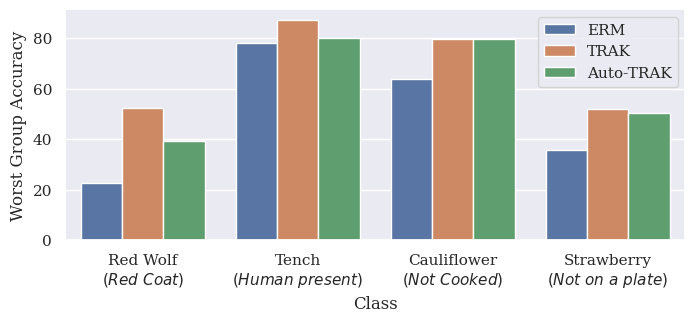

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = False

sns.set(style='darkgrid', font='serif')
summary = pd.DataFrame([
    ["Red Wolf\n$\it{(Red\ Coat)}$",22.62, 52.38, 39.29],
    ["Tench\n$\it{(Human\ present)}$", 78.12, 86.88, 80.00],
    ["Cauliflower\n$\it{(Not\ Cooked)}$",63.64, 79.55, 79.40],
    ["Strawberry\n$\it{(Not\ on\ a\ plate)}$",35.58, 51.92, 50.48],
], columns=['Class', 'ERM', 'TRAK', 'Auto-TRAK'])
summary = summary.melt('Class', var_name="Method", value_name='Worst Group Accuracy')
sns.barplot(data=summary, x='Class', y='Worst Group Accuracy', hue='Method', ax=ax)
plt.legend(loc='upper right')
plt.savefig("imagenet_fairness.pdf", bbox_inches='tight')
plt.show()